<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>


<div align="center">
    <img width="512px" src='BERT_Layer.png' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

- to run this notebook, connect to the colab GPU 
- clone tensorlfow models offical repo 
    https://github.com/tensorflow/models.git
- install the requirments from the offical repo
- and check tensorflow installation
- check nvidia-smi

In [1]:
! nvidia-smi

Tue Dec  1 19:39:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
print( tf.__version__)

2.3.0


clone tensorflow model official repo

In [3]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2319/2319), done.
remote: Total 2650 (delta 511), reused 1351 (delta 298), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 25.61 MiB/s, done.
Resolving deltas: 100% (511/511), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [4]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

     |████████████████████████████████| 71kB 5.5MB/s 
     |████████████████████████████████| 215kB 11.5MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 14.5MB 253kB/s 
     |████████████████████████████████| 471kB 56.6MB/s 
     |████████████████████████████████| 102kB 15.2MB/s 
     |████████████████████████████████| 25.9MB 126kB/s 
     |████████████████████████████████| 174kB 60.6MB/s 
     |████████████████████████████████| 3.6MB 56.4MB/s 
     |████████████████████████████████| 1.1MB 51.3MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 358kB 56.4MB/s 
     |████████████████████████████████| 1.1MB 49.8MB/s 
     |████████████████████████████████| 11.6MB 198kB/s 
     |████████████████████████████████| 36.7MB 88kB/s 
     |████████████████████████████████| 276kB 53.9MB/s 
     |████████████████████████████████| 2.2MB 37.2MB/s 
     |████████████████████████████████| 92kB 11.4MB/s 


restart the kernal after this installation

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [4]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Hub version:  0.10.0
GPU is available


Donwload the Quora Insincere Questions Classification data can be found https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip. Decompress and read the data into a pandas DataFrame.

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv("https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip",
                 compression='zip')

Explore the dataset

In [6]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [7]:
df.shape

(1306122, 3)

<AxesSubplot:ylabel='Frequency'>

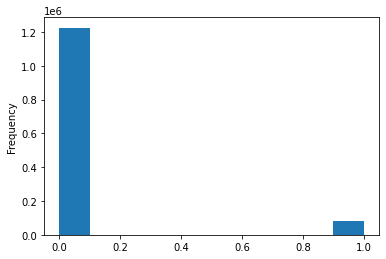

In [8]:
df.target.plot(kind='hist')

split the dataset

In [21]:
train_df , remaining = train_test_split(df, 
                                        random_state= 42,
                                        train_size=0.0095,
                                        stratify=df.target)
valid_df , _ = train_test_split(remaining, 
                                random_state= 42,
                                train_size=0.0075,
                                stratify=remaining.target)

In [22]:
print("shape of the training df > ",train_df.shape)
print("shape of the validation df > ",valid_df.shape)

shape of the training df >  (12408, 3)
shape of the validation df >  (9702, 3)


Create tf.data.Datasets for Training and Evaluation

In [23]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values, valid_df['target'].values))

In [24]:
for text, target in train_data.take(2):
  print(text, target)

tf.Tensor(b'What is the age of JESUS on the first day of the first month of AD?', shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b"Why isn't the fourth season of Flash on Netflix yet, and when will it come onto Netflix?", shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int64)


*Download a Pre-trained BERT Model from TensorFlow Hub*

In [25]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""
label_list = [1, 0]
max_seq_length = 128
train_batch_size = 128

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()  
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


**Tokenize and Preprocess Text for BERT**

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using classifier_data_lib's constructor InputExample provided in the BERT library.

In [26]:
def to_feature(text , label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(None,
                                      text_a=text.numpy(),
                                      text_b=None,
                                      label= label.numpy())
  
  features = classifier_data_lib.convert_single_example(0,
                                                        example,
                                                        label_list,
                                                        max_seq_length,
                                                        tokenizer)
  return (features.input_ids , features.input_mask, features.segment_ids, features.label_id)

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

Wrap a Python Function into a TensorFlow op for Eager Execution

In [27]:
def to_feature_map(text, label):
  input_ids , input_mask , segment_ids , label_id = tf.py_function(to_feature,
                                                                   inp=[text, label],
                                                                   Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])
  x ={
      'input_word_ids': input_ids,
      'input_mask': input_mask,
      'input_type_ids': segment_ids
      }
  return (x, label_id)

Create a TensorFlow Input Pipeline with tf.data

In [28]:
with tf.device('/cpu:0'):
  # training
  train_data = (train_data.map(to_feature_map,
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # validation
  valid_data= (valid_data.map(to_feature_map,
                              num_parallel_calls= tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

The resulting tf.data.Datasets return (features, labels) pairs, as expected by keras.Model.fit:

# Building the model

In [29]:
def create_model():
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), 
                                           dtype=tf.int32,
                                           name="input_word_ids")
    input_mask  = tf.keras.layers.Input(shape=(max_seq_length,),
                                        dtype= tf.int32,
                                        name= "input_mask")
    input_type_ids  = tf.keras.layers.Input(shape=(max_seq_length,),
                                        dtype= tf.int32,
                                        name= "input_type_ids")
    pooled_output , sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    drop = tf.keras.layers.Dropout(.4)(pooled_output)
    dense_layer_1 =  tf.keras.layers.Dense(128, activation='relu', name='layer_dense_1')(drop)
    dense_layer_2 =  tf.keras.layers.Dense(64, activation='relu', name='layer_dense_2')(dense_layer_1)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(dense_layer_2)
    model = tf.keras.Model(
        inputs= {
            "input_word_ids":input_word_ids,
          "input_mask":input_mask,
          "input_type_ids": input_type_ids
        },
        outputs = output
    )
    return model

## Fine-Tune BERT for Text Classification

In [30]:
model = create_model()
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss =tf.keras.losses.BinaryCrossentropy(),
              metrics= [tf.keras.metrics.BinaryAccuracy()]
              )
model.summary() 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

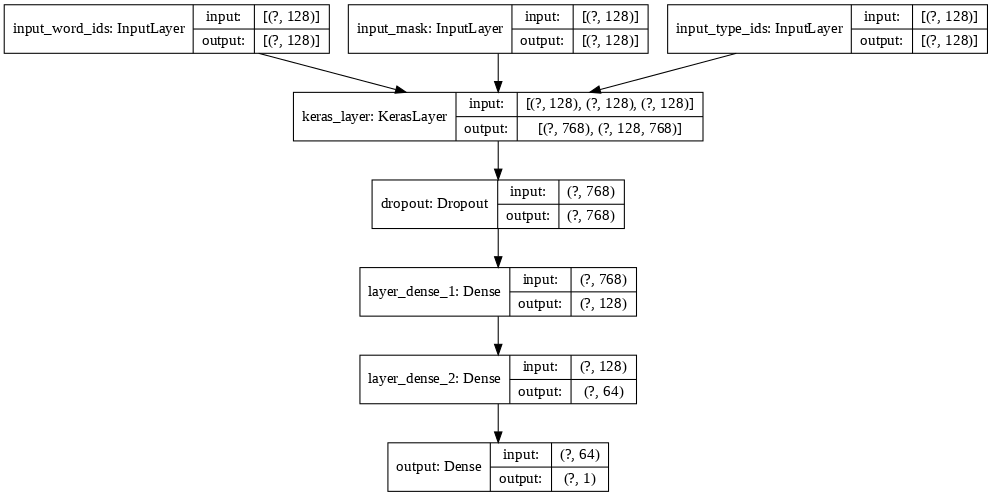

In [31]:
tf.keras.utils.plot_model(model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=76)

In [32]:
# Train model
epochs = 4
history = model.fit(
    train_data,
    validation_data= valid_data,
    epochs=epochs,
    verbose= 1
)

Epoch 1/4
387/387 [==============================] - ETA: 0s - loss: 0.1753 - binary_accuracy: 0.9345WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_test_batch_end` time: 0.2613s). Check your callbacks.


387/387 [==============================] - 393s 1s/step - loss: 0.1753 - binary_accuracy: 0.9345 - val_loss: 0.1160 - val_binary_accuracy: 0.9543
Epoch 2/4
387/387 [==============================] - 401s 1s/step - loss: 0.1002 - binary_accuracy: 0.9623 - val_loss: 0.1430 - val_binary_accuracy: 0.9542
Epoch 3/4
387/387 [==============================] - 402s 1s/step - loss: 0.0593 - binary_accuracy: 0.9784 - val_loss: 0.1608 - val_binary_accuracy: 0.9488
Epoch 4/4
387/387 [==============================] - 402s 1s/step - loss: 0.0325 - binary_accuracy: 0.9893 - val_loss: 0.1987 - val_binary_accuracy: 0.9538


In [33]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

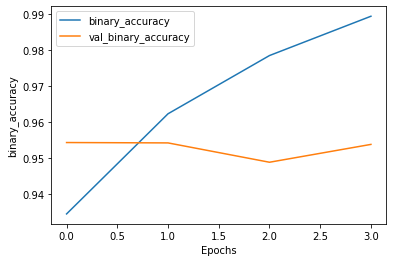

In [35]:
plot_graphs(history, 'binary_accuracy')